<a href="https://colab.research.google.com/github/brian-calderon/Project_IV_Chip-Pattern-CNN/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
# add your src path to the system path so that it will search there for lib
# imports
sys.path.append('/content/drive/MyDrive/Academic/NYCDSA/Project-IV (Chip Pattern CNN)/src')
# verify that its added
sys.path

In [ ]:
# Now you can import your custom modules and run code from them
# NOTE: dont name stuff test.py since 'test' is a reserved name
# NOTE: You can't define .ipynb as modules, they have to be .py files.
from mymodule import run
run()

You just ran this func! Yay!


# ToDo's:

> Your accuracy is ~84% and the loss curves are weird, need to drilldown on these.
Train for more than 20 epochs and replot


> Can you train a CNN to recognize random and good maps so that you can gather all other maps?



# Main

In [1]:
################################################################################
#---------------------------Python Lib imports----------------------------------
################################################################################
import os
import sys
import pandas as pd
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
################################################################################
#---------------------------Custom Lib imports----------------------------------
################################################################################
# change path to src so you can import modules
sys.path.append('/content/drive/MyDrive/Academic/NYCDSA/Project-IV (Chip Pattern CNN)/src')
from clean import cleanDF
from plotmap import plot_map
from split import split
from resize_images import resize_images
from one_hot_encode import one_hot_encode
from generators import test_gen, train_gen, validate_gen
from models import lenet
################################################################################
#------------------------------------Globals------------------------------------
################################################################################
# r converts to raw string so you don't need to escape the "\"
ROOT = r'/content/drive/MyDrive/Academic/NYCDSA/Project-IV (Chip Pattern CNN)'
RAW_DATA = '%s/data/LSWMD.pkl' %ROOT # '%s' is used to append strings
CWD_PATH = os.getcwd() # Current working directory
map_size = (64,64)
################################################################################
#------------------------------------Code---------------------------------------
################################################################################
# def run():
# Mount g-drive
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
# change CWD to the Project_IV directory in g-drive
os.chdir('%s' %ROOT)
# Load raw wafer map data into df
df=pd.read_pickle(RAW_DATA)
# Clean the raw df
wafermaps=cleanDF(df).clean()
# Divide into three df's:
# labeled: maps that are labeled (including 'none')
# un_lableled: unlabeled maps
# label_pattern: labeled maps excluding 'none'
labeled = wafermaps[(wafermaps['failuretype'] != '[]')]
labeled.reset_index(inplace = True, drop = True)
un_labeled = wafermaps[(wafermaps['failuretype'] == '[]')]
un_labeled.reset_index(inplace = True, drop = True)
label_pattern = wafermaps[~(wafermaps['failuretype'].isin(['[]','none']))]
# Recode the failuretypes since you removed some:
label_pattern=cleanDF.encode(label_pattern)
label_pattern.reset_index(inplace = True, drop = True)
# Total number of failure types (i.e. classes)
classes = label_pattern['failurenum'].max() +1
# Split into test/train data
test_df, train_df = split(label_pattern)
# Setting the GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Compiling model
lenet = lenet((*map_size,3),classes) # Remember to unpack the map_size tuple
lenet.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = 1E-3),
    metrics = ["accuracy"]
)
# Training model
batch_size = 100
# NOTE: In order to use gen's for the training and validation data set the gen's
# must both be infinite!
history = lenet.fit(train_gen(train_df,batch_size,map_size), steps_per_epoch = train_df.shape[0] // batch_size,\
                    validation_data = validate_gen(test_df,batch_size,map_size), validation_steps = test_df.shape[0] // batch_size, \
                    epochs = 20)
# if __name__ == '__main__':
#   run()

/content/drive/MyDrive/Academic/NYCDSA/Project-IV (Chip Pattern CNN)/src/clean.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['failurenum'] = df['failuretype'].astype(object).replace(encoder)


Epoch 1/20
250/250 [==============================] - 24s 73ms/step - loss: 0.5185 - accuracy: 0.8110 - val_loss: 2.1728 - val_accuracy: 0.4020
Epoch 2/20
250/250 [==============================] - 19s 74ms/step - loss: 0.2667 - accuracy: 0.9015 - val_loss: 0.3937 - val_accuracy: 0.8540
Epoch 3/20
250/250 [==============================] - 18s 70ms/step - loss: 0.2018 - accuracy: 0.9271 - val_loss: 0.4710 - val_accuracy: 0.8160
Epoch 4/20
250/250 [==============================] - 17s 70ms/step - loss: 0.1485 - accuracy: 0.9480 - val_loss: 0.4157 - val_accuracy: 0.8660
Epoch 5/20
250/250 [==============================] - 18s 72ms/step - loss: 0.1157 - accuracy: 0.9598 - val_loss: 0.5411 - val_accuracy: 0.7940
Epoch 6/20
250/250 [==============================] - 18s 73ms/step - loss: 0.1019 - accuracy: 0.9649 - val_loss: 0.4806 - val_accuracy: 0.8340
Epoch 7/20
250/250 [==============================] - 17s 70ms/step - loss: 0.0684 - accuracy: 0.9765 - val_loss: 0.4762 - val_accuracy:

# EDA

In [ ]:
################################################################################
#--------------------------------Wafer Dims-------------------------------------
################################################################################
print(f"The largest wafer map is: ",max(clean_df['waferMapDim']),\
        "\nThe smallest wafer map is :",min(clean_df['waferMapDim']))
unique_waferDim = np.unique(clean_df['waferMapDim'])
print("There are: ",unique_waferDim.shape[0],"different map dimensions")

The largest wafer map is:  (300, 202) 
The smallest wafer map is : (6, 21)
There are:  632 different map dimensions


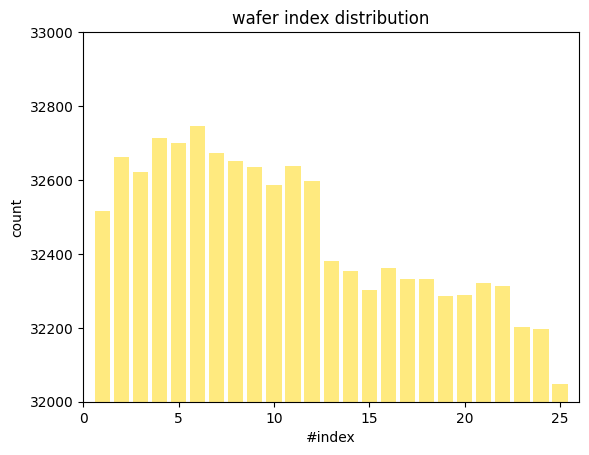

In [ ]:
################################################################################
#----------------------------Wafer Index Bar Plot-------------------------------
################################################################################
unique_index = np.unique(clean_df['waferIndex'], return_counts=True)
plt.bar(unique_index[0], unique_index[1], color='gold', align='center', alpha=0.5)
plt.title('wafer index distribution')
plt.xlabel('#index')
plt.ylabel('count')
plt.xlim(0, 26)
plt.ylim(32000, 33000)
plt.show()

In [ ]:
################################################################################
#--------------------------------Exploring Data---------------------------------
################################################################################
print(clean_df.iloc[:,1:6].nunique()) # Unique elements excluding the wafermap column
display("Clean DF: ",clean_df[['failureType','dieSize']]\
        .rename(columns = {'dieSize': '# of Maps'})\
        .groupby(['failureType']).count())

dieSize            1266
lotName           46293
waferIndex           25
trainTestLabel        3
failureType          10
dtype: int64


'Clean DF: '

,# of Maps
failureType,
Center,4294
Donut,555
Edge-Loc,5189
Edge-Ring,9680
Loc,3593
Near-full,149
Random,866
Scratch,1193
[],638507


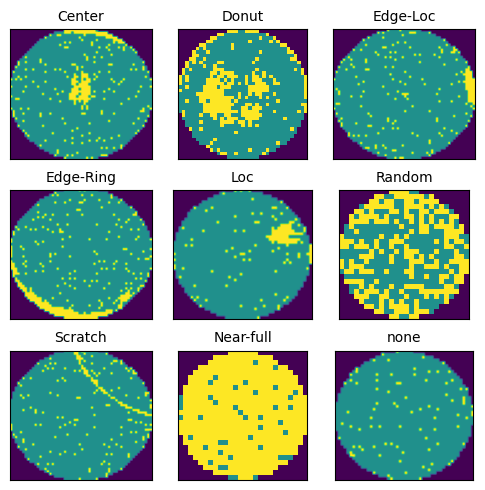

In [ ]:
################################################################################
#----------------------Plotting Fail Pattern Exm's------------------------------
################################################################################
# encoders = {
#     'Center': 0,
#     'Donut': 1,
#     'Edge-Loc': 2,
#     'Edge-Ring': 3,
#     'Loc': 4,
#     'Random': 5,
#     'Scratch': 6,
#     'Near-full': 7,
#     'none': 8,
#     '[]': 9
#     }
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(5,5))
# Because you defined the subplots as 2x4 then the ax handle is a 2x4 matrix
# In order to make it easier to loop through in a for loop you can flatten
# the handle to an array that's 1x8, that's what ravel does, it just flattens.
ax = ax.ravel(order='C')
for i in range(9):
    # your referencing the encoders dict you made earlier.
    # list(encoders) gives back a list of the keys.
    # You need to use .iloc[x,y] to get maps as an array, other methods retrieve
    # them as object or series and can't be plotted.
    img = clean_df[(clean_df['failureType'] == list(encoders)[i])].iloc[0,0]
    ax[i].imshow(img)
    ax[i].set_title(clean_df[(clean_df['failureType'] == list(encoders)[i])]\
                    .iloc[0,5],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

<ipython-input-17-1b439cc4124f>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(fail_count.index.values, rotation=45, ha='right')
<ipython-input-17-1b439cc4124f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(fail_count.index.values[2:9], rotation=45, ha='right')


[Text(0, 0, 'Edge-Ring'),
 Text(1, 0, 'Edge-Loc'),
 Text(2, 0, 'Center'),
 Text(3, 0, 'Loc'),
 Text(4, 0, 'Scratch'),
 Text(5, 0, 'Random'),
 Text(6, 0, 'Donut')]

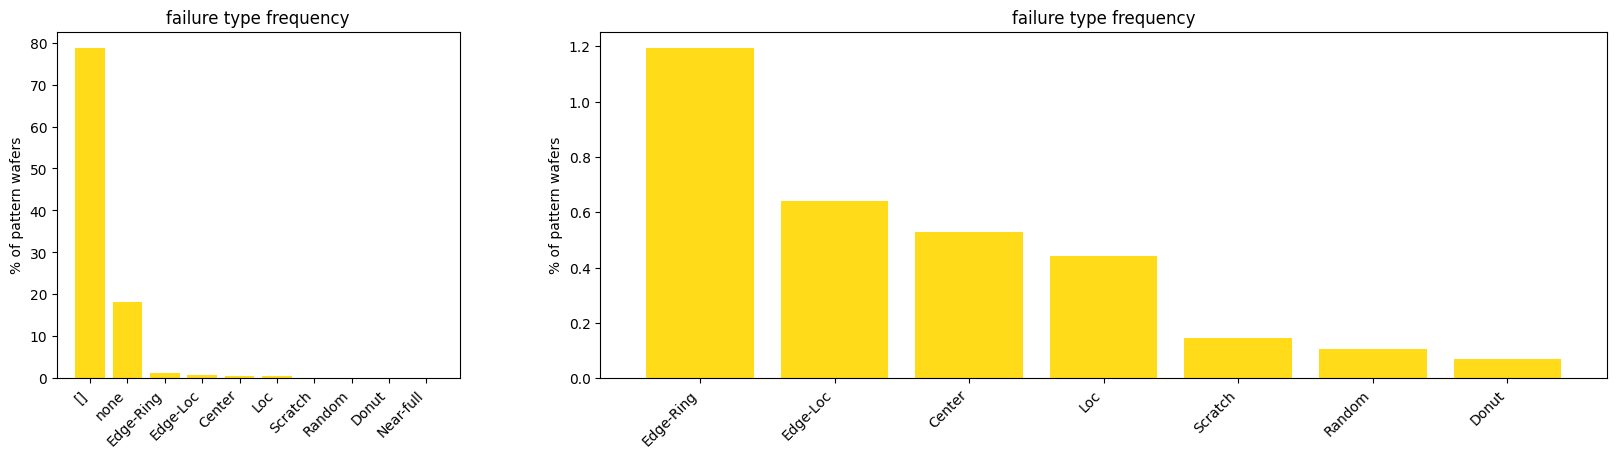

In [ ]:
################################################################################
#--------------------------Exploring Fail Patterns------------------------------
################################################################################
fail_count = clean_df[['failureType','dieSize']].rename(columns = {'dieSize': '# of Maps'})\
        .groupby(['failureType']).count().sort_values(by = "# of Maps",ascending=False)
# fail_count['# of Maps']
# Create bar chart of failure type patterns
# uni_pattern=np.unique(df_pattern['failureNum'], return_counts=True)
fig = plt.figure(figsize=(20, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.bar(fail_count.index.values,(fail_count['# of Maps']/clean_df.shape[0])*100,\
        color='gold', align='center', alpha=0.9)
ax1.set_title("failure type frequency")
ax1.set_ylabel("% of pattern wafers")
ax1.set_xticklabels(fail_count.index.values, rotation=45, ha='right')

ax2.bar(fail_count.index.values[2:9],(fail_count['# of Maps'][2:9]/clean_df.shape[0])*100,\
        color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(fail_count.index.values[2:9], rotation=45, ha='right')

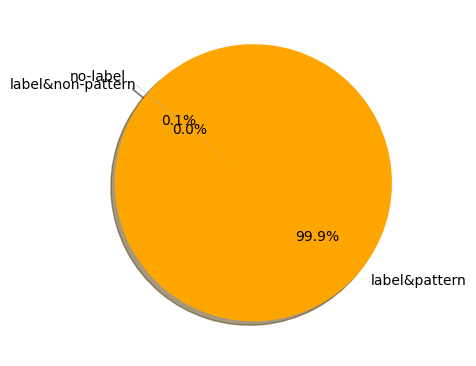

In [ ]:
################################################################################
#--------------------------Exploring Fail Patterns------------------------------
################################################################################
fig = plt.figure(figsize=(20, 4.5))
ax1 = plt.subplot()
# Create bar chart of failure type patterns
# uni_pattern=np.unique(df_pattern['failureNum'], return_counts=True)
# Create pie chart of Map labeling
colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
# fail_count['# of Maps'][8] = wafers with label []
# fail_count['# of Maps'][0:8].sum() = wafers with pattern
#
wafer_counts = [fail_count['# of Maps'][8],fail_count['# of Maps'][0:8].sum(), \
                fail_count['# of Maps'][9]]
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(wafer_counts, explode=explode, labels=labels, colors=colors, \
        autopct='%1.1f%%', shadow=True, startangle=140)
del fail_count

In [ ]:
################################################################################
# ------------------Exploring the failuretype = [] -----------------------------
################################################################################
# Description: This block randomly chooses 20 wafer maps that are classified
# '[]' in the failure type and plots them
# Press Crl+Enter to continously run this block and get different maps plotted
# subset_maps = clean_df.loc[clean_df['failureType']=='[]']
# a = rd.randrange(subset_maps.shape[0])
# if a>20:
#     subset_maps = subset_maps.iloc[a-20:a]
# else:
#     subset_maps = subset_maps.iloc[0:20]

# fig, axs = plt.subplots(math.ceil(subset_maps.shape[0]/4),4)
# for i in range(math.ceil(subset_maps.shape[0]/4)):
#   for j in range(4):
#     axs[i,j].imshow(subset_maps.iloc[j+4*i,0])
#     axs[i,j].set_title(str(subset_maps.iloc[j+4*i,5])+': '+str(subset_maps.iloc[j+4*i,3]))

# Conclusion: The '[]' type maps are mostly sprinkled random defects. However,
# there are some unclassified maps as well. For now its ok to get rid of them
# for the data analysis.

In [ ]:
################################################################################
# ------------------Exploring the failuretype = none maps-----------------------
################################################################################
# Description: This block randomly chooses 20 wafer maps that are classified
# 'none' in the failure type and plots them
# Press Crl+Enter to continously run this block and get different maps plotted
# subset_maps = clean_df.loc[clean_df['failureType']=='[]']
# a = rd.randrange(subset_maps.shape[0])
# if a>20:
#     subset_maps = subset_maps.iloc[a-20:a]
# else:
#     subset_maps = subset_maps.iloc[0:20]

# fig, axs = plt.subplots(math.ceil(subset_maps.shape[0]/4),4)
# for i in range(math.ceil(subset_maps.shape[0]/4)):
#   for j in range(4):
#     axs[i,j].imshow(subset_maps.iloc[j+4*i,0])
#     axs[i,j].set_title(str(subset_maps.iloc[j+4*i,5])+': '+str(subset_maps.iloc[j+4*i,3]))

# Conclusion: The 'none' type maps are mostly sprinkled random defects.
# No obvious patterns are present.
# its ok to get rid of them for the data analysis.

In [ ]:
################################################################################
#-------------------Verifying all small dim maps are valid---------------------
################################################################################
# Some of the maps under '[]' and 'none' that had small dims were cutoff or
# incomplete, we want to make sure all the maps in the 'label_pattern' subset
# are complete maps.
small_dims = label_pattern['waferMapDim'].sort_values().unique()[0:10]
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize=(5,5))
ax = ax.ravel(order='C')
for i in range(10):
    # You need to use .iloc[x,y] to get maps as an array, other methods retrieve
    # them as object or series and can't be plotted.
    img = label_pattern[(label_pattern['waferMapDim'] == small_dims[i])].iloc[0,0]
    ax[i].imshow(img)
    ax[i].set_title(label_pattern[(label_pattern['waferMapDim'] == small_dims[i])]\
                    .iloc[0,6],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

# Prep for CNN Input

## Generators for test/train/validation

In [ ]:
################################################################################
# Cute little func to plot results of custom gen's
################################################################################
decoder_df = test_df[['failuretype','failurenum']].groupby('failuretype').min().reset_index()
for map, label_array in train_gen(test_df,5):
  encoded_labels = np.where(label_array == 1)[1][:]
  for i in range(encoded_labels.shape[0]):
    plot_map(map[i,...,2],
             list(decoder_df[decoder_df['failurenum']==encoded_labels[i]]['failuretype'])
             )

## Filtering

In [ ]:
# loading libraries
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from scipy import interpolate
from scipy import stats

In [ ]:
################################################################################
#----------------------Figuring out measure.label------------------------------
################################################################################
# label works by assigning labels starting from "1,2,3...", it assumes that anything with a value of "0" is background and will not be considered within the
# labeling process. However, you can change that, if you actually have "0's" in your data set that you WANT to label, then you just set background =-1. This
# way only values with "-1" will be considered background (which typically don't occur). You could also set background = 100, or some other positive number that
# you think is not in your dataset, but is safer to set it to something that is unlikely to appear in your input such as "-1".
# Connectivity defines how many orthongal hops are needed to consider another cell (w/ the same value) a neighbour. "2" is default and means orthogongal and diagonal
# neighbours (total=8) are considered. Connectivity=1 means only diagonal neighbours are considered.
x = np.matrix([
  [1, 0, 0, 2, 1, 2, 0, 0, 0, 0],
  [0, 0, 2, 1, 1, 1, 2, 0, 0, 0],
  [0, 2, 1, 2, 2, 2, 1, 2, 0, 0],
  [2, 1, 1, 2, 2, 2, 1, 1, 2, 0],
  [0, 2, 1, 2, 2, 2, 1, 2, 0, 0],
  [0, 0, 2, 1, 1, 1, 2, 0, 0, 0],
  [0, 0, 0, 2, 1, 2, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])


# NOTE display can't recognize new line escapes "\n"
print(f"This is x w/o any labeling:\n {x}")
print(f"\nThis is \"labeled\" x w/ background=0 & connectivity=2 (defaults):\n\
{measure.label(x)}")
print(f"\nThis is \"labeled\" x w/ background=0 & connectivity=1:\n \
{measure.label(x,connectivity = 1)}")
print(f"\nThis is \"labeled\" x w/ background!=0 & connectivity=2:\n \
{measure.label(x,background=-1)}")




This is x w/o any labeling:
 [[1 0 0 2 1 2 0 0 0 0]
 [0 0 2 1 1 1 2 0 0 0]
 [0 2 1 2 2 2 1 2 0 0]
 [2 1 1 2 2 2 1 1 2 0]
 [0 2 1 2 2 2 1 2 0 0]
 [0 0 2 1 1 1 2 0 0 0]
 [0 0 0 2 1 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

This is "labeled" x w/ background=0 & connectivity=2 (defaults):
[[1 0 0 2 3 2 0 0 0 0]
 [0 0 2 3 3 3 2 0 0 0]
 [0 2 3 2 2 2 3 2 0 0]
 [2 3 3 2 2 2 3 3 2 0]
 [0 2 3 2 2 2 3 2 0 0]
 [0 0 2 3 3 3 2 0 0 0]
 [0 0 0 2 3 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]

This is "labeled" x w/ background=0 & connectivity=1:
 [[ 1  0  0  2  3  4  0  0  0  0]
 [ 0  0  5  3  3  3  6  0  0  0]
 [ 0  7  8  9  9  9 10 11  0  0]
 [12  8  8  9  9  9 10 10 13  0]
 [ 0 14  8  9  9  9 10 15  0  0]
 [ 0  0 16 17 17 17 18  0  0  0]
 [ 0  0  0 19 17 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]

This is "labeled" x w/ background!=0 & connectivity=2:
 [[1 2 2 3 4 3 5 5 5 5]
 [2 2 3 4 4 4 3 5 5 5]
 [2 3 4 3 3 3 4 3 5 5]
 [3 4 4 3 3 3 4 4 3 5]
 [5 3 4 3 3 3 4 3 5 5]
 [5 5 3 4 4 4 3 5 5 5]
 [5 5 5 3 4 3 5 5 5

In [ ]:
def filter_maps(input_df):
  maps = []
  labels = []
  filtered_maps = []
  # Saving some maps and labels
  for map, label in test_gen(input_df,input_df.shape[0]):
    maps.append(map)
    labels.append(label)
  # Making the maps into a np.array for ease of use
  maps = np.squeeze(np.array(maps))
  # Filtering maps
  for i in range(maps.shape[0]):
    # plot_map(scratch_maps[0][i,:,:,2])
    filtered_map = measure.label(maps[i,:,:,2], connectivity=1)
    tgt_pattern = stats.mode(filtered_map[filtered_map>0], axis = None)
    tgt_coords = np.where(filtered_map == tgt_pattern[0])
    background_coords = np.where(filtered_map != tgt_pattern[0])
    filtered_map[background_coords] = 0
    filtered_maps.append(filtered_map)
  # Converting to np.array for ease of use
  filtered_maps = np.array(filtered_maps)

  return(filtered_maps, maps[:,:,:,2])

In [ ]:
filtered, unfiltered = filter_maps(test_df[test_df['failureType'] == 'Scratch'])

In [ ]:
nrows

75

In [ ]:
# n_rows = math.ceil(unfiltered.shape[0] / 2)
n_rows = 75
n_cols = 4
# fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, sharex=True, sharey=True)
lx,ly = 200,180
margin = 0.3 #inch
spacing =0.1 #inch
imsize = 0.6 #inch

figwidth=n_cols*imsize+(n_cols-1)*spacing+2*margin
figheight=n_rows*imsize*ly/lx+(n_rows-1)*spacing+2*margin

left=margin/figwidth
bottom = margin/figheight

fig, ax = plt.subplots(nrows=n_rows,ncols=n_cols, sharex=True, sharey=True)
fig.set_size_inches(figwidth,figheight)
fig.subplots_adjust(left=left, bottom=bottom, right=1.-left, top=1.-bottom,
                    wspace=spacing/imsize, hspace=spacing/imsize*lx/ly)
# ax = ax.ravel(order='C')
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    if j % 2 == 0:
      ax[i][j].imshow(unfiltered[i])
      # ax[i][j].set_title("Unfiltered",fontsize=10)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
    else:
      ax[i][j].imshow(filtered[i])
      # ax[i][j].set_title("filtered",fontsize=10)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
# plt.tight_layout()
# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 0.5, bottom = 0, right = 0.2, left = 0,
#             hspace = 0, wspace = 0)
# plt.margins(0,0)
plt.show()

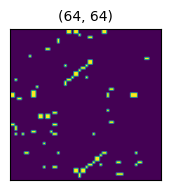

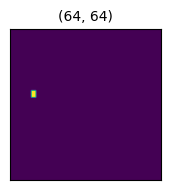

In [ ]:
################################################################################
#----------------------Filtering Scratches------------------------------
################################################################################
np.set_printoptions(edgeitems=30, linewidth=100000,
    formatter=dict(float=lambda x: "%.3g" % x))

scratches = test_df[test_df['failureType'] == 'Scratch']
scratches.reset_index(inplace = True, drop = True)
scratch_maps = []
scratch_labels = []
for map, label in test_gen(scratches,scratches.shape[0], (64,64)):
  scratch_maps.append(map)
  scratch_labels.append(label)
# for i in range(scratch_maps[0].shape[0]):
#     plot_map(scratch_maps[0][i,:,:,2])

# map = map.waferMap[1]
# map[np.where(map == 1)] = 0
# plot_map(map[0,:,:,2])
# filtered_map = np.zeros(map[0,:,:,2].shape)
filtered_map = measure.label(scratch_maps[0][0,:,:,2], connectivity=1)
plot_map(scratch_maps[0][0,:,:,2])

tgt_pattern = stats.mode(filtered_map[filtered_map>0], axis = None)
tgt_coords = np.where(filtered_map == tgt_pattern[0])
background_coords = np.where(filtered_map != tgt_pattern[0])
filtered_map[background_coords] = 0
# # filtered_map[coords] = 9
plot_map(filtered_map)

# img = map
# zero_img = np.zeros(img.shape)
# img_labels = measure.label(img,connectivity=1, background=0)
# img_labels = img_labels-1
# fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
# ax = ax.ravel(order='C')
# if img_labels.max()==0:
#     no_region = 0
# else:
#     info_region = stats.mode(img_labels[img_labels>-1], axis = None)
#     no_region = info_region[0]
# np.where(img_labels==no_region)
# zero_img[np.where(img_labels==no_region)] = 2
# ax[i].imshow(zero_img)
# ax[i].set_title("test",fontsize=10)
# ax[i].set_xticks([])
# plt.tight_layout()
# plt.show()

In [ ]:
scratch_maps = np.squeeze(np.array(scratch_maps))
print(scratch_maps.shape)
# scratch_maps = np.squeeze(scratch_maps, axis =0)
# print(scratch_maps.shape)

(149, 64, 64, 3)


# CNN

## Importing Libs

### Plot model architecture

In [ ]:
lenet.summary()
# Plotting model arquitecture
from tensorflow.keras.utils import plot_model
plot_model(lenet, show_shapes=True, show_layer_names=True)

### Training model

### Evaluating Model

In [8]:
from typing import Tuple, Union
################################################################################
#----------------------------Test Data Generator--------------------------------
################################################################################
# NOTE: You can define a map_size to resize the images if you want, the default
# is (64,64)
# NOTE: This test_gen is NOT infinite while the validate_gen is.
def test_gen2(input_df: pd.DataFrame,
             batch_size: int = 100,
             map_size: Tuple[int,int] = (64,64),
             classes: int = None):

  if not isinstance(input_df, pd.DataFrame):
    raise TypeError("input_df must be a pandas DataFrame")
  if not isinstance(batch_size, int):
    raise TypeError("batch_size must be an int")
  if not isinstance(map_size, tuple):
    raise TypeError("map_size must be a tuple")
  if not isinstance(classes, int):
    raise TypeError("classes must be an int")

  x_test, y_test = [], []

  if classes is None:
    # Finding the total number of fail mode within the df
    classes = input_df['failurenum'].max()+1
  else:
    classes = classes

  # Sampling batch_size of data from the the Input
  test = input_df.sample(n=batch_size, replace=False)#, random_state=1)
  test.reset_index(inplace = True, drop = True)# reseting index inplace

  # Resize maps
  resized_maps = resize_images(test['wafermap'], map_size)

  # One hot encode maps, this returns a np.array and also resizes maps.
  encoded_maps = one_hot_encode(resized_maps, map_size )

  # Creates an array of dim: [batch_size] X ([classes]) of all zeros
  labels = np.zeros((encoded_maps.shape[0], classes))

  # fills in only the column corresponding to the failNum with "1"
  for i in range(encoded_maps.shape[0]):
      labels[i][test['failurenum'][i]] = 1
  del test

  x_test.extend(encoded_maps)
  y_test.extend(labels)
  x_test = np.array(x_test)
  y_test = np.array(y_test)
  # display("there are ",len(x_test),"maps for testing")
  # num += 1
  yield(x_test, y_test)

In [5]:
################################################################################
#------------------------Getting loss & Accuracy--------------------------------
################################################################################
fail_patterns = test_df['failuretype'].unique()
losses = []
accuracies = []
labels = []
for label in fail_patterns:
  input_df = test_df[(test_df['failuretype'] == label)]
  no_maps = test_df[(test_df['failuretype'] == label)].shape[0]
  # using the generator call to evaluate
  (loss, accuracy) = lenet.evaluate(test_gen2(input_df,no_maps, classes=7), verbose = 0)
  losses.append(loss)
  accuracies.append(accuracy)
  labels.append(label)

# Converting to dataframe since its easier to handle than lists
eval_df = pd.DataFrame({'losses':losses, 'accuracies': accuracies,\
                        'labels': labels})
# Sorting by accuracy column
eval_df.sort_values(by = 'accuracies', inplace = True)
eval_df

,losses,accuracies,labels
7,3.627388,0.458333,Scratch
1,2.462602,0.636364,Donut
4,1.636697,0.652778,Loc
0,0.979772,0.790698,Center
2,0.556238,0.865385,Edge-Loc
6,0.238089,0.941176,Random
3,0.329374,0.948454,Edge-Ring
5,0.000003,1.000000,Near-full


<ipython-input-9-ebb43db87cf8>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(eval_df.labels, rotation=45, ha='right')


[Text(0, 0, '45.83'),
 Text(0, 0, '63.64'),
 Text(0, 0, '65.28'),
 Text(0, 0, '79.07'),
 Text(0, 0, '86.54'),
 Text(0, 0, '94.12'),
 Text(0, 0, '94.85'),
 Text(0, 0, '100')]

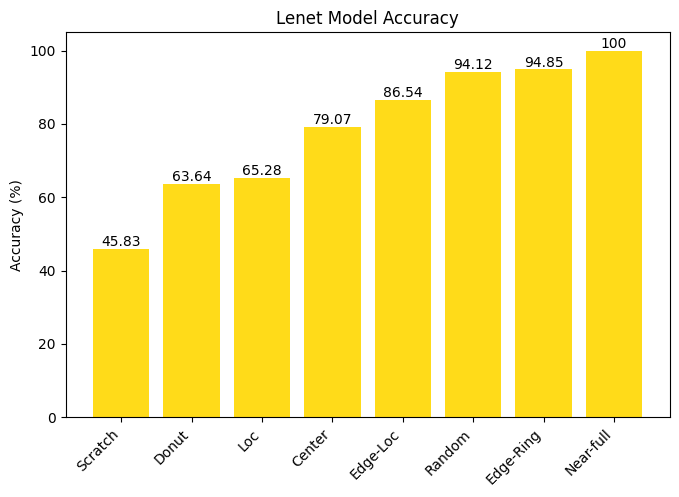

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
################################################################################
#------------------------Plotting loss & Accuracy-------------------------------
################################################################################
fig = plt.figure(figsize=(30, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
ax = plt.subplot(gs[0])

ax.bar(eval_df.labels,round(eval_df.accuracies*100,2),color='gold', align='center', alpha=0.9)
ax.set_title("Lenet Model Accuracy")
ax.set_ylabel("Accuracy (%)")
ax.set_xticklabels(eval_df.labels, rotation=45, ha='right')
# display labels on each bar
ax.bar_label(ax.containers[0], label_type='edge')

### EDA on model results

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


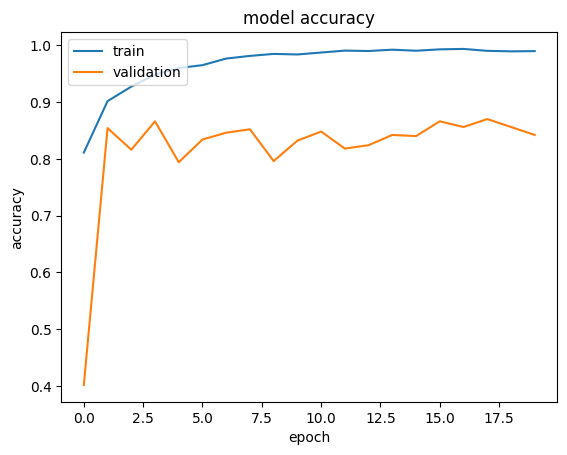

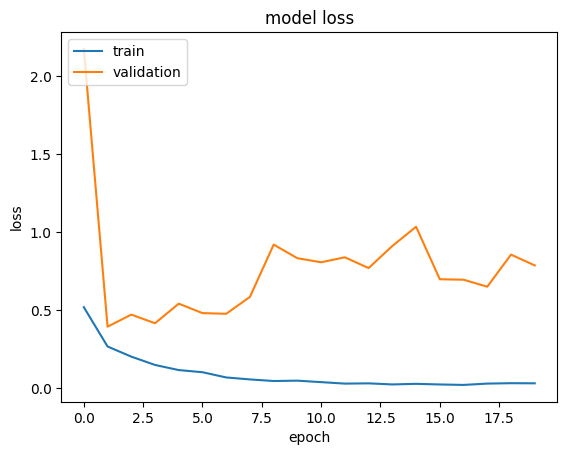

In [10]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### EDA on wrong predictions

In [45]:
decoder_df = label_pattern.groupby(['failuretype','failurenum']).count().reset_index().iloc[:,0:2]
temp_df.info()
temp_df.head()
temp_df[temp_df['failurenum']==0]['failuretype']
label_pattern.info()

0    Center
Name: failuretype, dtype: string

In [50]:
################################################################################
#-----------------------------Making predcitions--------------------------------
################################################################################
decoder_df = label_pattern.groupby(['failuretype','failurenum']).count().reset_index().iloc[:,0:2]
label_pattern.groupby(['failuretype','failurenum']).count()
predict_maps =[]
predict_labels = []
no_predictions = 15000
# save some maps and labels from the test_gen to use in .predict
for map, label in test_gen(label_pattern,no_predictions, classes=8):
  predict_maps.append(map)
  predict_labels.append(label)
# Convert the matrix of y-labels to an array with encoded keys only
actual_labels = np.nonzero(predict_labels[0] ==  1)[1]
# Translating the encoded labels to named labels
actual_labels = list(actual_labels)
for idx, item in enumerate(actual_labels):
  actual_labels[idx] = decoder_df[decoder_df['failurenum']==item]['failuretype']

# Make prediction and extract indice of predictions (which is the encoded key)
predicted_labels = np.argmax(lenet.predict(predict_maps, verbose = 0),1)
# Translating the encoded labels to named labels
predicted_labels = list(predicted_labels)
for idx, item in enumerate(predicted_labels):
  predicted_labels[idx] = decoder_df[decoder_df['failurenum']==item]['failuretype']
# print("Predicted Labels:", predicted_labels, "\nActual Labels:   ",actual_labels)

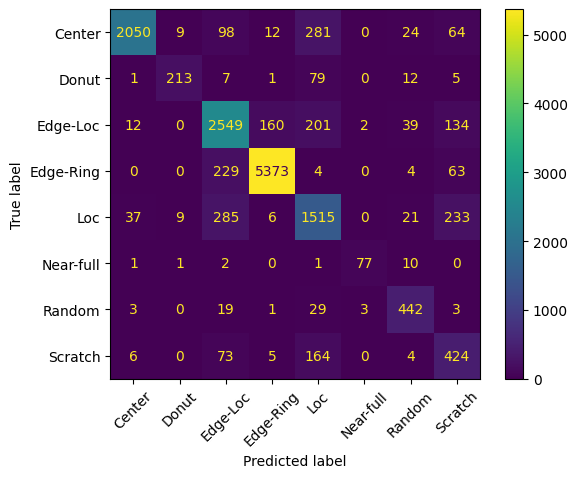

In [51]:
################################################################################
#---------------------------Compute Confusion Matrix----------------------------
################################################################################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cnf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,\
                              display_labels= np.unique(np.array(actual_labels + predicted_labels))
                              )
disp.plot()
disp.ax_.xaxis.set_tick_params(rotation=45)

IndexError: ignored

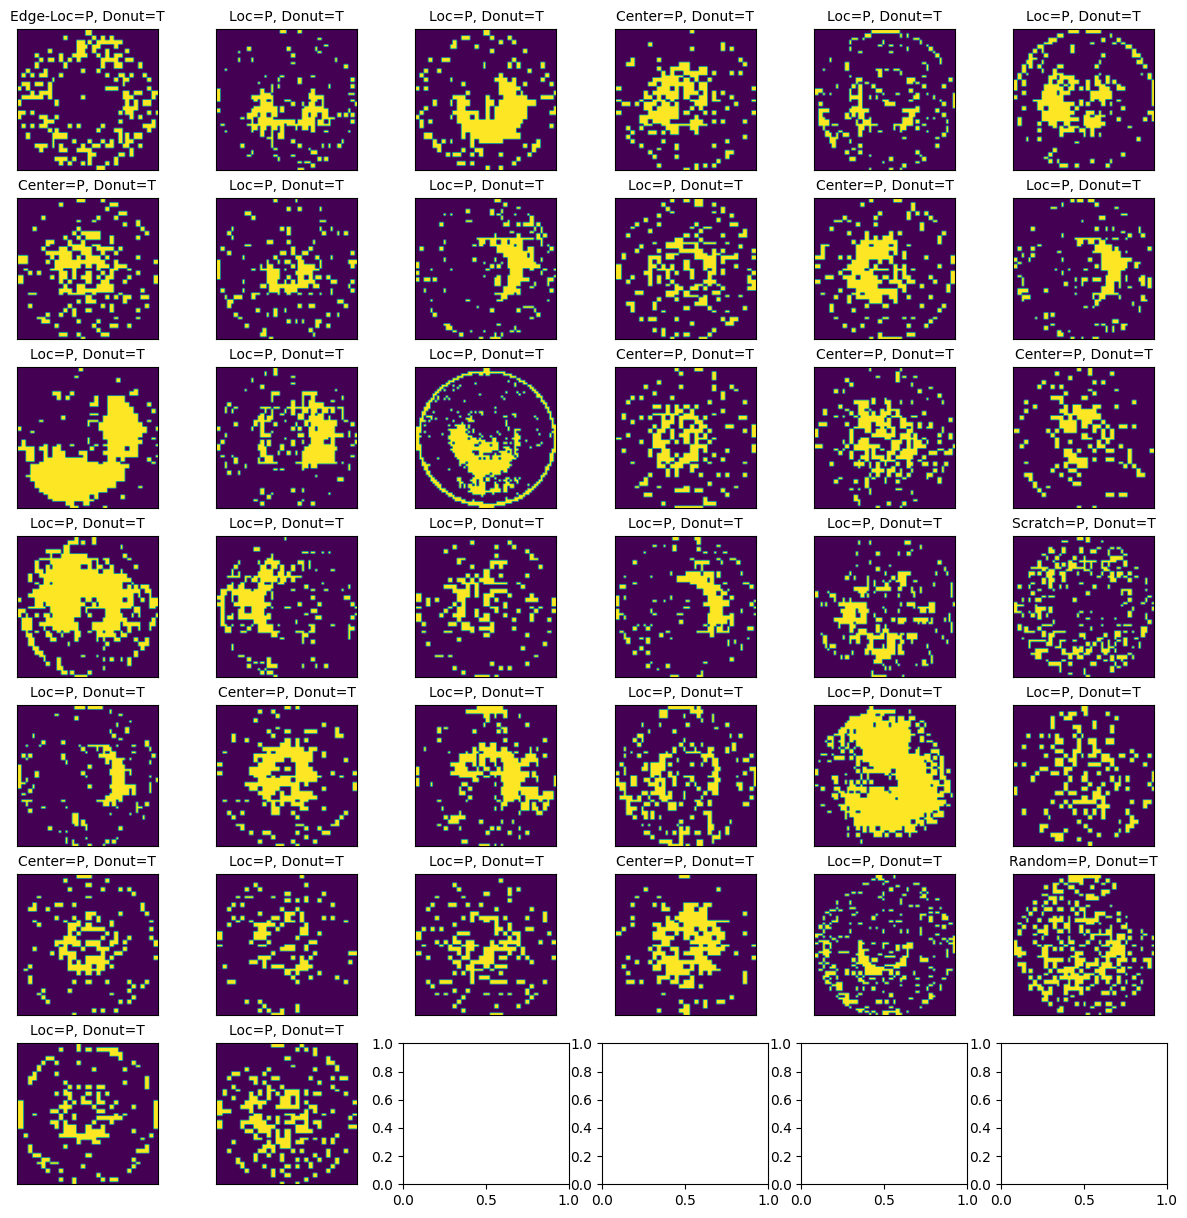

In [ ]:
################################################################################
#------------------------------Analyzing Donuts---------------------------------
################################################################################
# changing to pandas series since you want to to be able to save the index's
# and its easier this way.
true_donuts = pd.Series(actual_labels)
true_donuts = true_donuts[true_donuts == 'Donut']
# changing to pandas series since you want to to be able to save the index's
# and its easier this way.
predicted_donuts = pd.Series(predicted_labels)
predicted_donuts = predicted_donuts[true_donuts.index]
# Save incorrect images and labels
incorrect_indices = predicted_donuts.compare(true_donuts).index
incorrect_images = predict_maps[0][incorrect_indices,:,:,2]
incorrect_labels = [predicted_donuts[i] for i in incorrect_indices]
correct_labels = [true_donuts[i] for i in incorrect_indices]

# Plot wrong Donut predictions
nrows = math.ceil(incorrect_images.shape[0] / 6)
# ncols = nrows
fig, ax = plt.subplots(nrows = nrows, ncols = 6, figsize=(15,15))

ax = ax.ravel(order='C')
for i in range(ax.shape[0]):
    img = incorrect_images[i,:,:]
    ax[i].imshow(img)
    ax[i].set_title(incorrect_labels[i]+"=P, "+correct_labels[i]+"=T",fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
################################################################################
#------------------------Inspecting wrong predictions---------------------------
################################################################################
# Save incorrect images and labels
incorrect_indices = [i for i in range(len(actual_labels)) if actual_labels[i] != predicted_labels[i]]
incorrect_images = predict_maps[0][incorrect_indices,:,:,2]
incorrect_labels = [predicted_labels[i] for i in incorrect_indices]
# [incorrect_labels.append(list(encoders.keys())[key]) for key in\
#  predicted_labels[incorrect_indices]]
correct_labels = [actual_labels[i] for i in incorrect_indices]
# [correct_labels.append(list(encoders.keys())[key]) for key in \
#  np.where(predict_labels[0] ==  1)[1][incorrect_indices]]
# Plot wrong predictions
i = 0
for map in incorrect_images:
  plot_map(map,(incorrect_labels[i]+"=P",correct_labels[i]+"=T") )
  i += 1

## Other Models

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 223, 223, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 16)      2320      
                                                                 
 batch_normalization_1 (Bat  (None, 111, 111, 16)      64        
 chNormalization)                                                
                                                        

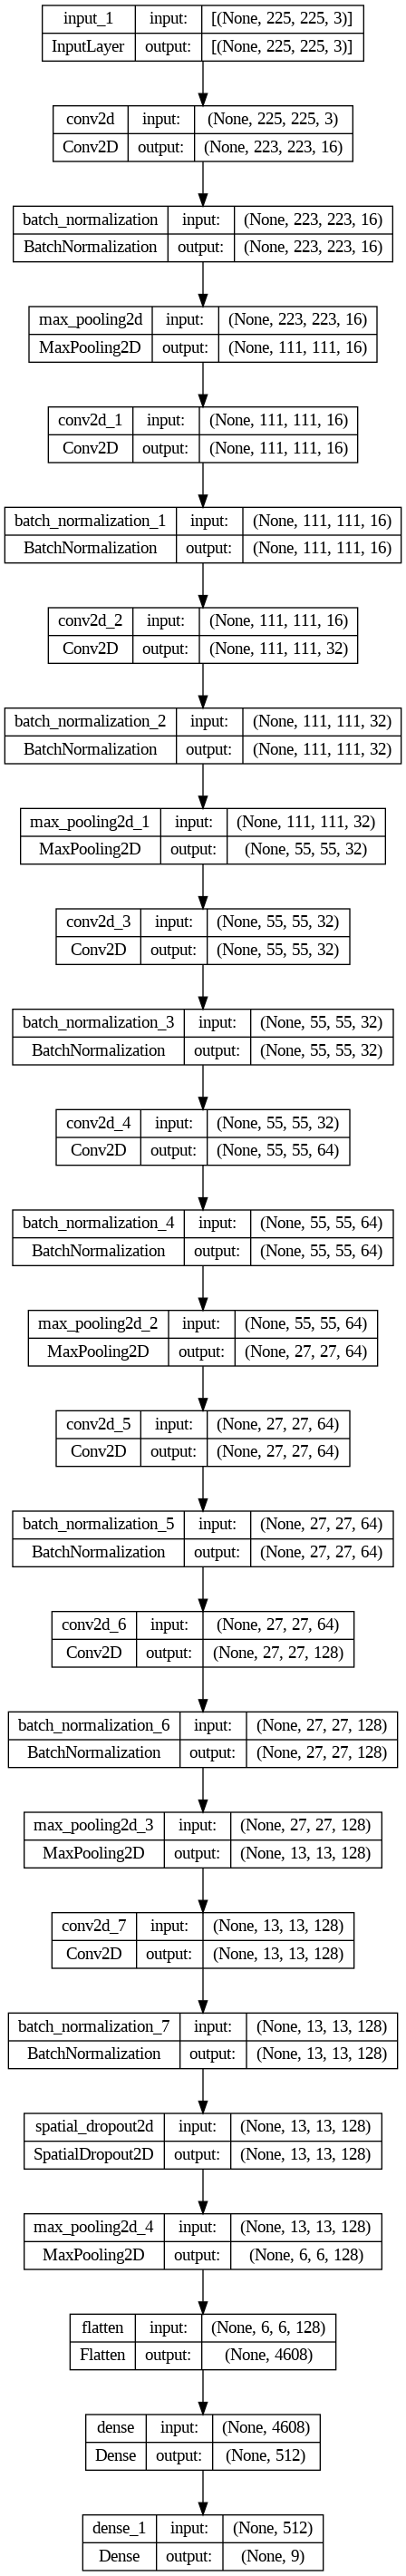

In [ ]:
################################################################################
#------------------------------Model Definition---------------------------------
################################################################################
model = Sequential([
    # Input
    Input(shape=(225, 225, 3)),

    # block 1
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'),
    # Ref.: https://arxiv.org/abs/1502.03167
    # This normalizes each batch of inputs to the next layer, it helps to reduce
    # internal covariance (variability between batches) and improves accuracy.
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 5
    SpatialDropout2D(rate=0.2),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(9, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Plotting model arquitecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
################################################################################
#------------------------------Running Model------------------------------------
################################################################################

history = model.fit(x_train,y_train, validation_data=(x_test, y_test), epochs=20, batch_size=100)
histories.append(history)

In [ ]:
################################################################################
#----------------------------Evaluating Model-----------------------------------
################################################################################
for history in histories:
    # accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Misc Coding Notes

*   Ctrl + Shift + Enter to run a highlighted subsection of a block of code
*   Ctrl + / Commenting
*   type() checks variable type
*   axis = 0 "rows" 1 "columns"
*   Display the docstring of a function Ctrl + Shift (after running)
*   df.shape gives the x-y dim of a dataframe
* ctrl + F8: Run all cells prior to current cell

# Misc Coding Recipes

In [ ]:
# The below line increases the output width of np.array's so that you plot
# entire rows in one line and see a better depiction of a matrix.
np.set_printoptions(edgeitems=30, linewidth=100000,
    formatter=dict(float=lambda x: "%.3g" % x))
# Everything after is just getting a maps and plotting it.
map = test_df[test_df['failureType'] == 'Scratch'].loc[:,['waferMap','waferMapDim','failureType']]
map.reset_index(inplace = True, drop = True)
map = map.waferMap[0]
map[np.where(map == 1)] = 0
# print(np.stack(map))
print(map)

In [ ]:
# How to concatenate two MxN arrays into a third LxNxM array
aug_test = label_pattern[label_pattern['failureType'] == 'Donut']['waferMap']\
            .reset_index(drop = True).iloc[0]
aug_img = augment_images(aug_test)
# In order for this to work you need add a dimension to each of the input
# two dimensional arrays to make them three dimensional and then you can
# concatenate them
test = np.concatenate((aug_test[np.newaxis,:,:],aug_img[np.newaxis,:,:]),axis=0)

In [ ]:
# How to print maps as a matrix and visual them
smallest_map = df_label.iloc[172949]['waferMap']
smallest_map.shape
print(np.matrix(smallest_map))

In [ ]:
# If you have an n-dim numpy array that you would like to save into a specific
# cell of a dataframe you have you use a bracket wrapper '[]' when you assign it
# Exm#1:
clean_df.iloc[0,6] = [clean_df.iloc[1,0]]

# Exm#2: Using the return of the user defined function madppad
clean_df.iloc[0,6] = [mappad(225,225,clean_df.iloc[1,0])]

In [ ]:
!git remote set-url origin <URL> # Changes url of mask "origin"
!git remote -v # shows all the masks you currently have set

In [ ]:
# You can appyl multiple .apply() to any given series. It's execution order is from left to right
# df_temp = df['failureType'].apply(np.squeeze).apply(lambda x: x=='none')


In [ ]:
# CWD_PATH = os.getcwd()
# os.chdir('%s/..' % os.getcwd())
# print(os.getcwd())

/content


In [ ]:
# The code below reads in a pickle sequentially into an empty object which is
# ultimately a dictionary.

# objects = []
# with (open("DATA_PATH", "rb")) as openfile: # with-as is a common method used for opening files, it masks the open() function with a variable pointing to it named 'openfile'
#     while True: #infinite loop, you'll need a break at somepoint
# # try and break are part of error handling methods you can google this.
#         try:
#             objects.append(pickle.load(openfile))
#         except EOFError:
#             break

# Old Code Snippets

In [ ]:
################################################################################
###################### MapPad function to Pad Maps##############################
################################################################################
#-------------Finding the max X and Y size of any map--------------------------
# Ans: MaxX=212 ; MaxY=204
# # shape_max_X = 0
# # shape_max_Y = 0
# # for i in range(len(clean_df)):
# #   if clean_df.iloc[i,0].shape[0] > shape_max_X:
# #     shape_max_X = clean_df.iloc[i,0].shape[0]
# #   if clean_df.iloc[i,0].shape[1] > shape_max_Y:
# #     shape_max_Y = clean_df.iloc[i,0].shape[1]
# # print(shape_max_X,",",shape_max_Y)
# #------------------Function to pad maps----------------------------------------
# # It takes target X and Y dimensions and wafer map as input, then pads the wafer
# # map with 0's until it has the target dimensions, finally returning the padded
# # wafer map.
# def mappad(target_Xdim, target_Ydim, wafer_map):
#   left_pad = math.ceil((target_Xdim - wafer_map.shape[1])/2)
#   right_pad = math.floor((target_Xdim - wafer_map.shape[1])/2)
#   top_pad = math.ceil((target_Ydim - wafer_map.shape[0])/2)
#   bottom_pad = math.floor((target_Ydim - wafer_map.shape[0])/2)
#   padded_map = np.pad(wafer_map,
#                 pad_width= ((top_pad,bottom_pad),(left_pad,right_pad))
#                 )
#   # Used to check if padidng worked:
#   # display("Dimension after padding: ",padded_map.shape)
#   # fig, axs = plt.subplots(1,2)
#   # axs[0].imshow(wafer_map)
#   # axs[0].set_title("Raw Map")
#   # axs[1].imshow(padded_map)
#   # axs[1].set_title("Padded Map")
#   return padded_map

In [ ]:
################################################################################
# getting rid of 'none' and '[]' type maps and continuing the pre-processing.
################################################################################
# clean_df = clean_df.loc[(clean_df['failureType'] != 'none') & (clean_df['failureType'] != '[]')]
# clean_df.reset_index(inplace = True, drop = True)# reseting index inplace
# print(clean_df.head())
# # clean_df.groupby(['trianTestLabel','failureType']).count()
# display("Clean DF: ",clean_df[['trianTestLabel','failureType','dieSize']]\
#         .rename(columns = {'dieSize': '# of Maps'})\
#         .groupby(['trianTestLabel','failureType']).count())

In [ ]:
################################################################################
#----------------------------Prep'ing Train Data--------------------------------
################################################################################
# x_train, y_train = [], []
# class_num = 8 # Limit to only labeled fail patterns [0,1,2,3,4,5,6,7]
# dsize = (64, 64)
# temp_label = label_pattern
# # while temp_label.shape[0] > 1000:
# for i in range(30):
#   # Sampling some of data from the the labeled data only
#   train = temp_label.sample(n=500, replace=False)
#   # Concat sampled df to original df
#   temp_label = pd.concat([train, temp_label])
#   # Use index difference to remove sampled data from original df so that the
#   # next time you sample you don't sample the same data (i.e. sample w/o
#   # replacement)
#   temp_label = temp_label.loc[temp_label.index.difference(train.index),]
#   # You reset the index on the sampled df AFTER you use it to index difference
#   train.reset_index(inplace = True, drop = True)# reseting index inplace
#   # Resize maps (default is 64,64)
#   resized_maps = resize_images(train['waferMap'])
#   display("Temp Label size:", temp_label.shape[0])
#   # This Augments (i.e. distorts) images. Note that it will return np.array
#   # per definition of the function, which is what you need for CNN.
#   augmented_maps = augment_images(resized_maps)
#   del resized_maps
#   # One hot encode maps
#   encoded_maps = encode_images(augmented_maps)
#   del augmented_maps
#   # Creates an array of all zeros
#   labels = np.zeros((encoded_maps.shape[0], class_num))
#   # fills in only the column corresponding to the failNum with "1"
#   for i in range(encoded_maps.shape[0]):
#       labels[i][train['failureNum'][i]] = 1
#   # Saving to a test array. The shape is (24990,225,225,3)
#   x_train.extend(encoded_maps)
#   y_train.extend(labels)


# x_train = np.array(x_train)
# y_train = np.array(y_train)
# display("there are ",len(x_train),"maps for training")

In [ ]:
################################################################################
#----------------------------Prep'ing Test Data---------------------------------
################################################################################
# x_test, y_test = [], []
# class_num = 8 # Limit to only labeled fail patterns [0,1,2,3,4,5,6,7]
# dsize = (64, 64)
# # Sampling 2% of data from the the labeled data only (510w)
# test = label_pattern.sample(frac=0.02, replace=True, random_state=1)
# test.reset_index(inplace = True, drop = True)# reseting index inplace
# # One hot encode maps, this returns a np.array and also resizes maps.
# encoded_maps = encode_images(test['waferMap'], 64, 64)
# # Creates a 510x8 array of all zeros
# labels = np.zeros((encoded_maps.shape[0], class_num))
# # fills in only the column corresponding to the failNum with "1"
# for i in range(encoded_maps.shape[0]):
#     labels[i][test['failureNum'][i]] = 1
# del test
# x_test.extend(encoded_maps)
# y_test.extend(labels)
# x_test = np.array(x_test)
# y_test = np.array(y_test)
# display("there are ",len(x_test),"maps for testing")

In [ ]:
################################################################################
########## Padding with zeros to make all maps the same size####################
################################################################################
# # Add column of Padded maps to DF
# clean_df['Padded_Map'] = None # Add an empty column to store the padded maps
# # moving the Padded Map column after the waferMap column
# cols = clean_df.columns.tolist()
# cols = cols[0:1] + cols[-1:] + cols[1:6]
# clean_df = clean_df[cols]
# # The line below isolates the waferMap column and applies to each row (i.e.
# # each map) the function mappad which is defined above, the resulting padded map
# # is then added as a new row to the column 'Padded_Map'.
# clean_df['Padded_Map'] = clean_df['waferMap'].apply(lambda map: mappad(225,225,map))
# clean_df.head()

In [ ]:
################################################################################
#-------------------Split into Train, Validate, Test----------------------------
#-----------------Disproportionate Stratified Sampling--------------------------
################################################################################
# We choose equal number of wafer maps from each group, even though some groups
# have more maps than others. Drawback with this is that we limit the max maps
# per group to the group with least maps, in this case this is Group6 = 149,
# so our dataset goes from 25,529 to 149*8 = 1,192.
test_df = label_pattern.groupby(['failureNum'], group_keys = False).apply(lambda x: x.sample(149))
test_df.reset_index(inplace = True, drop = True)# reseting index inplace
# strata1_df.head()
display("Disproportionate Stratified DF: ",test_df[['failureNum','failureType','dieSize']]\
        .rename(columns = {'dieSize': '# of Maps'}).groupby(['failureNum','failureType']).count())
# # This just randomizes the rows fo the DF:
# strata1_df = strata1_df.sample(frac=1, random_state=1).reset_index(drop=True)
# # Defines length ot train(60%), validation(15%), and test_data (25%)
# train_length = int(0.6*len(strata1_df))
# valid_length = int(0.15*len(strata1_df))
# test_length = int(0.25*len(strata1_df))
# df_train, df_valid, df_test = strata1_df[:train_length] , strata1_df[train_length : train_length + valid_length] , strata1_df[train_length + valid_length : train_length + valid_length+test_length]
# print("\n------------------------------\nTraining Data length: ",len(df_train))
# print("Validation Data Length: ",len(df_valid),"\nTest Data Lenth: ",len(df_test),"\n------------------------------")
# display("Training DF: ",df_train[['Encoded_Labels','failureType','dieSize']].rename(columns = {'dieSize': '# of Maps'}).groupby(['Encoded_Labels','failureType']).count())
# display("Validation DF: ",df_valid[['Encoded_Labels','failureType','dieSize']].rename(columns = {'dieSize': '# of Maps'}).groupby(['Encoded_Labels','failureType']).count())
# display("Test DF: ",df_test[['Encoded_Labels','failureType','dieSize']].rename(columns = {'dieSize': '# of Maps'}).groupby(['Encoded_Labels','failureType']).count())

'Disproportionate Stratified DF: '

,,# of Maps
failureNum,failureType,
0,Center,149
1,Donut,149
2,Edge-Loc,149
3,Edge-Ring,149
4,Loc,149
5,Random,149
6,Scratch,149
7,Near-full,149


In [ ]:
label_pattern.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,waferMapDim,failureNum
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683,lot1,20.0,Training,Loc,"(45, 48)",4
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460,lot2,12.0,Training,Edge-Loc,"(53, 58)",2
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460,lot2,13.0,Training,Edge-Loc,"(53, 58)",2
38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460,lot2,14.0,Training,Edge-Loc,"(53, 58)",2
39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460,lot2,15.0,Training,Edge-Loc,"(53, 58)",2


In [ ]:
proportions = label_pattern[['failureNum','failureType','dieSize']].groupby(['failureNum','failureType']).count()/label_pattern.shape[0]
proportions['dieSize'] = proportions['dieSize'].round(2)
display("Proportions Per Group: ",proportions.rename(columns = {'dieSize': 'Proportions'}))

'Proportions Per Group: '

,,Proportions
failureNum,failureType,
0,Center,0.17
1,Donut,0.02
2,Edge-Loc,0.20
3,Edge-Ring,0.38
4,Loc,0.14
5,Random,0.03
6,Scratch,0.05
7,Near-full,0.01


In [ ]:
################################################################################
#-------------------Split into Train, Validate, Test----------------------------
#-------------------Proportionate Stratified Sampling---------------------------
################################################################################
# We choose un-equal number of wafer maps from each group,choosing the # of
# samples in the same proportion as they appear in each group.
test_df = label_pattern
proportions = test_df[['failureNum','failureType','dieSize']].groupby(['failureNum','failureType']).count()/test_df.shape[0]
proportions['dieSize'] = proportions['dieSize'].round(2)
display("Proportions Per Group: ",proportions.rename(columns = {'dieSize': 'Proportions'}))
# np.select rows from a DF based on certain conditions, here we select first the
# rows of the encoded labels (i.e. strata2_df['Encoded_Labels'].eq(0) selects all rows
# with label '0') and then fills in the rows according to the condition (i.e.
# percents.iloc[0,0] selects 0.14 and fills in all rows with label '0' with 0.14)
# This is a way of creating a percents columns that can be used to filter rows
# based on this column later on.
test_df['Proportions'] = np.select([test_df['failureNum'].eq(0),
                                    test_df['failureNum'].eq(1),
                                    test_df['failureNum'].eq(2),
                                    test_df['failureNum'].eq(3),
                                    test_df['failureNum'].eq(4),
                                    test_df['failureNum'].eq(5),
                                    test_df['failureNum'].eq(6),
                                    test_df['failureNum'].eq(7)] ,
                                     [proportions.iloc[0,0],proportions.iloc[1,0],
                                      proportions.iloc[2,0],proportions.iloc[3,0],
                                      proportions.iloc[4,0],proportions.iloc[5,0],
                                      proportions.iloc[6,0],proportions.iloc[7,0]])
# test_df[['failureNum','failureType','Proportions']]\
#           .groupby('failureNum').mean().round(2)
# Selects rows from a DF based on certain conditions from the percents column,
# here we first group by the encoded labels then sample each group based on the
# percents defined in the Proportions column (i.e. df['Proportions'].iloc[0])
test_df = test_df.groupby('failureNum', group_keys = False)\
                      .apply(lambda x: x.sample(frac = x['Proportions'].iloc[0]))
test_df.reset_index(inplace = True, drop = True)# reseting index inplace
display(test_df[['failureNum','failureType','dieSize']]
        .rename(columns ={'dieSize': '# of Maps'})
        .groupby(['failureNum','failureType'])
        .count().sort_values(by = '# of Maps',ascending = False))

'Proportions Per Group: '

,,Proportions
failureNum,failureType,
0,Center,0.17
1,Donut,0.02
2,Edge-Loc,0.20
3,Edge-Ring,0.38
4,Loc,0.14
5,Random,0.03
6,Scratch,0.05
7,Near-full,0.01


<ipython-input-74-e4a529b22a24>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Proportions'] = np.select([test_df['failureNum'].eq(0),


,,# of Maps
failureNum,failureType,
3,Edge-Ring,3678
2,Edge-Loc,1038
0,Center,730
4,Loc,503
6,Scratch,60
5,Random,26
1,Donut,11
7,Near-full,1
